In [1]:
import os
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import  CountVectorizer

#!pip install  wordcloud
from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

nltk.download('punkt');
nltk.download('wordnet');
nltk.download('stopwords');



c:\Users\Simon Andersen\miniconda3\envs\BigData\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Preprocessing

#### Preprocessing is a huge chunk of the overall workload, as you may have noticed, and for text data, it involves some, but not usually all of the the following steps:

Document level preprocessing:
* Data cleaning (duplicate and noise removal)
* Data construction (deriving the features)
* Data reformatting and restructuring 

Word level preprocessing:
* Word cleaning (Removal of illegal features and numbers, upper cases letters, mispellings etc)
* Removal of irrelevant words (stopwords)
* Tokenization
* n-gram construction
* Part-of-speech filtering
* Lemmatization
* Stemming
* Vectorization (embedding words as vectors in a large dimensional space)






In [2]:
data = pd.read_csv('data/conversations.csv')

N_conv = len(data['id'].unique())
Nrows = data.shape[0]
Nspeakers = len(data['speaker'].unique())

print('Number of conversations: ', N_conv)
print('Number of rows in conversations.csv: ', Nrows)
print('Number of speakers: ', Nspeakers)

print("Columns in conversations.csv: ", list(data.columns))


Number of conversations:  300
Number of rows in conversations.csv:  4039
Number of speakers:  349
Columns in conversations.csv:  ['id', 'timestamp', 'speaker', 'text']


Since we would like to extract information from entire conversations (possibly differentiated whether it is the patient or doctor speaking), we group the data by conversation. To also group by speaker, use the outcommented line of code instead.

Simply grouping by conversation means that each conversation takes up 1 row, and that our 'document' is a conversation

In [3]:

# Group data by conversation and speaker
data = data.groupby(['id'])['text'].apply(list).reset_index(name='text').astype(str)

# To make plots and printouts prettier, we'll make a shorthand for the conversation IDs
# by defining a new column called conversation index, or index for short
data['index'] = np.arange(len(data))

# To also group by speaker, uncomment the following line
#data = data.groupby(['id', 'speaker'])['text'].apply(list).reset_index(name='text').astype(str)

print(data.head())

                                     id  \
0  000890d3-ca87-4fcf-9825-877a1861588b   
1  016f462d-35d3-432a-aa5c-c085c935e711   
2  02ce4149-965a-4e5b-91c2-2a21b5ab50ee   
3  038a4758-29f2-48a1-b88d-a9af221746a6   
4  03b955fd-4771-4069-931d-dfa84f3be4e4   

                                                text  index  
0  ['Hello Isabelle! How have you been since our ...      0  
1  ['Good morning, Vanya! How have you been since...      1  
2  ['Hi Sophia! How are you doing today?', "Hi Ra...      2  
3  ["Hi Ming! It's great to see you again. How ha...      3  
4  ["Hello Zoey! It's great to see you again for ...      4  


In [4]:
# Remove rows with empty text
data = data.loc[data['text'].notna()]

# Remove leading and trailing spaces and square brackets
data['text'] = data['text'].map(lambda x: x.strip('[').strip(']').strip())

In [5]:
# Let's have a look at the data
data.loc[:,'text'].head(10)

0    'Hello Isabelle! How have you been since our l...
1    'Good morning, Vanya! How have you been since ...
2    'Hi Sophia! How are you doing today?', "Hi Raj...
3    "Hi Ming! It's great to see you again. How hav...
4    "Hello Zoey! It's great to see you again for o...
5    "Hi Cynthia! It's great to see you again. How ...
6    'Hello Eva! How have you been since our last s...
7    "Hello Hans! It's great to meet you. How are y...
8    'Hi Fiona! How are you doing today?', "Hi Ali!...
9    'Hello Anita! How have you been since our last...
Name: text, dtype: object

In [6]:
# Remove common words such as me, our, you etc.
stop_words = nltk.corpus.stopwords.words('english')

# Add some more stopwords, i.e. words to be removed
new_stopwords = ['hi', 'hello','welcome', 'yes']
stop_words.extend(new_stopwords)

from string import punctuation
print("List of words to be removed: ", stop_words)

# Decapitalize text
data['text'] = data['text'].apply(lambda x: x.lower())
# Remove numbers
data['text'] = data['text'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
# Remove punctuation
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(lambda x: tokenizer.tokenize(x))
# remove stop words
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x if word not in (stop_words)]))

print("\nFirst five rows of the text column after preprocessing:")
print("\n",data['text'].head())



List of words to be removed:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 


First five rows of the text column after preprocessing:

 0    isabelle since last session kwame okay meet go...
1    good morning vanya since last session good mor...
2    sophia today raj well thank great thanks askin...
3    ming great see since last meeting neil well th...
4    zoey great see annual review terrence well tha...
Name: text, dtype: object


In [7]:
# Define a function to find unique words in a text
def find_unique_words(text, word_list):
    for word in text.split():
        if word not in word_list:
            word_list.append(word)
    return

In [8]:
# Let's find the no. of words and no. of unique words in the dataset

# Number of words in dataset
Nwords = data['text'].apply(lambda x: len(x.split()));
unique_words_before_lemmatization = []

for row in data['text']:
    find_unique_words(row, unique_words_before_lemmatization)

Nunique_words_before_lemmatization = len(unique_words_before_lemmatization);
# sort unique words
unique_words = sorted(unique_words_before_lemmatization);

print("Number of words in dataset: ", Nwords.sum())
print("Number of unique words in dataset: ", Nunique_words_before_lemmatization)
print(" The first 100 unique words: ", unique_words[:100])

Number of words in dataset:  44247
Number of unique words in dataset:  3344
 The first 100 unique words:  ['abdominal', 'abilities', 'ability', 'able', 'abroad', 'absolutely', 'absorption', 'abundance', 'accept', 'acceptance', 'access', 'accessible', 'accidental', 'accidentally', 'accommodate', 'accommodates', 'accommodating', 'accomplish', 'accomplishment', 'accordingly', 'account', 'accountable', 'accurate', 'achievable', 'achieve', 'achieved', 'achievement', 'achievements', 'achieving', 'acid', 'acids', 'acknowledge', 'across', 'acting', 'action', 'active', 'actively', 'activities', 'activity', 'actually', 'acupuncture', 'adam', 'adapt', 'adapted', 'adapting', 'adapts', 'add', 'added', 'addiction', 'adding', 'addition', 'additional', 'additionally', 'additions', 'address', 'addresses', 'addressing', 'adequate', 'adherence', 'adjust', 'adjusted', 'adjusting', 'adjustment', 'adjustments', 'adjusts', 'admire', 'admit', 'adrenaline', 'adults', 'advance', 'advantage', 'adventure', 'advic

We see that different forms of the same words are present like e.g. ability and abilities. This introduces unnecessary redundancy, and we fix it by lemmatization below, i.e. reducing different words forms to their unconjugated 'base', like e.g. letting balls --> ball and   tried --> try. 

Another approach (which we won't use) is to reduce all words to their stem by using stemming (this approach will group different word classes together, letting e.g. analyze, analysis --> analy). 

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()

# Lemmatize dataframe. It can only lemmatize one word class at the time, so we need to specify the word classes
# (noun = n, verb = v, adjective = a, adverb = r, sattelite adjective = s) for each word in the text column
word_classes = ['n', 'v', 'a', 'r', 's']
for word_class in word_classes:
    data['text'] = data['text'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word, word_class) for word in x.split()]))

# Let's find the no. of unique words in the dataset after lemmatization
unique_words = []

for row in data['text']:
    find_unique_words(row, unique_words)
Nunique_words = len(unique_words);
# sort unique words
unique_words = sorted(unique_words);

print("Number of unique words in dataset after lemmatization: ", Nunique_words)
print("Through lemmatization, we have reduced the number of unique words by: ", Nunique_words_before_lemmatization - Nunique_words)
print(" The first 100 unique words after lemmatization: ", unique_words[:100])


Number of unique words in dataset after lemmatization:  2601
Through lemmatization, we have reduced the number of unique words by:  743
 The first 100 unique words after lemmatization:  ['abdominal', 'ability', 'able', 'abroad', 'absolutely', 'absorption', 'abundance', 'accept', 'acceptance', 'access', 'accessible', 'accidental', 'accidentally', 'accommodate', 'accomplish', 'accomplishment', 'accordingly', 'account', 'accountable', 'accurate', 'achievable', 'achieve', 'achievement', 'acid', 'acknowledge', 'across', 'act', 'action', 'active', 'actively', 'activity', 'actually', 'acupuncture', 'adam', 'adapt', 'add', 'addiction', 'addition', 'additional', 'additionally', 'address', 'adequate', 'adherence', 'adjust', 'adjustment', 'admire', 'admit', 'adrenaline', 'adult', 'advance', 'advantage', 'adventure', 'advice', 'advise', 'advocate', 'aerobic', 'aerosol', 'affect', 'affordable', 'afghan', 'afraid', 'african', 'afternoon', 'afterwards', 'age', 'ago', 'agree', 'agriculture', 'ah', 'ah

In [10]:
type(data['text'].iloc[0])

str

In [11]:
bdol =  data['text'].apply(lambda x: ' '.join([word for word in list(x) if word not in (stop_words)]))


In [12]:
# Join the different processed titles together.
long_string = ','.join(list(data['text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


# save cleaned data
data.to_csv('data/cleaned_conversations.csv', index=False)

At this point, we can go back and remove any additional words that we deem irrelevant. Also, it is probably a good idea to remove the doctor and patient names as well, as they are irrelevant and quite frequent

### TF-IDF
Let us construct a dataframe holding the tfidf score for all words. The tfidf score is a measure of the importance of each word, in the sense that 1) a word occurring in more documents is deemed more important 2) a word ocurring more frequently overall is deemed less important. Condition 2) reduces the importance of very common words.

To do use, we use a vectorizer, which assigns a tuple (conv_id, token_id) to each token (word in this case), as well as a tfidf score.

In [13]:
# Convert the text column to a list of strings
to=data['text'].tolist()
# Store the conversation indices in a list (for later use)
conv_idx = data.loc[:, 'index'].tolist()

# Initialize the vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Check if the list is empty
if len(to) == 0:
    print("The list is empty.")
else:
    # Create the tf-idf matrix
    tfidf_vector = tfidf_vectorizer.fit_transform(to)

# Let us print the first row of the tf-idf matrix
print("The TFIDF vector for the first row: \n", tfidf_vector[0])


The TFIDF vector for the first row: 
   (0, 1568)	0.04493845995638044
  (0, 339)	0.040870676013695546
  (0, 2311)	0.031918935828905676
  (0, 2348)	0.02477552478705962
  (0, 2372)	0.03214732814561372
  (0, 650)	0.0435627025355221
  (0, 725)	0.05316596915993369
  (0, 129)	0.042086996551970804
  (0, 970)	0.0424469474305596
  (0, 1281)	0.05175063143421985
  (0, 1820)	0.03588459298475393
  (0, 2389)	0.05915605340421464
  (0, 1266)	0.0343144361183155
  (0, 242)	0.05316596915993369
  (0, 2563)	0.02731178857086253
  (0, 985)	0.02348966338979585
  (0, 962)	0.04916198001373801
  (0, 1118)	0.055310109851448026
  (0, 973)	0.02835391573164724
  (0, 1341)	0.05950829343853036
  (0, 2173)	0.037866693720213146
  (0, 1594)	0.10410611790211162
  (0, 978)	0.08586306686456603
  (0, 570)	0.27058563927899343
  (0, 2374)	0.04375416283983878
  :	:
  (0, 2567)	0.09908618016404326
  (0, 651)	0.060735399997075445
  (0, 1937)	0.06338567790240937
  (0, 1371)	0.06379789064595374
  (0, 1854)	0.07155557739313725
  (0,

In [14]:
# Create a dataframe from the tf-idf matrix, with each column representation a word
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=conv_idx, columns=tfidf_vectorizer.get_feature_names_out())

In [15]:
tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 0 to 299
Columns: 2597 entries, abdominal to zone
dtypes: float64(2597)
memory usage: 5.9 MB


In [16]:
# Add a row with the document frequency for each word (number of documents in which the word appears)
tfidf_df.loc['Document_Frequency'] = (tfidf_df > 0).sum()

In [17]:
# Let's have a look
tfidf_df.tail()

,abdominal,ability,able,abroad,absolutely,absorption,abundance,accept,acceptance,access,...,yusuf,zainab,zen,zereshk,zest,zhang,zinc,zoe,zoey,zone
296,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297,0.0,0.0,0.070521,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,0.0,0.0,0.000000,0.0,0.051202,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
299,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Document_Frequency,8.0,7.0,74.000000,1.0,74.000000,4.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0


In [18]:
# To find the tf-idf score for a specific word (and their document frequency), simply do

tfidf_slice = tfidf_df[['health', 'stress', 'sleep']]


In [19]:
# We see that only 'health' is present in the first/last 5 rows and occurs in 203 documents
tfidf_slice

,health,stress,sleep
0,0.000000,0.0,0.0
1,0.100584,0.0,0.0
2,0.000000,0.0,0.0
3,0.000000,0.0,0.0
4,0.034899,0.0,0.0
...,...,...,...
296,0.000000,0.0,0.0
297,0.000000,0.0,0.0
298,0.035509,0.0,0.0
299,0.000000,0.0,0.0


From tfidf_df we'll construct another Pandas dataframe, where each row contains the conversation id, the word, and its
tfidf score. This enables us to analyze the word importances on a word level as opposed to a document level

In [20]:
# Drop the row with the document frequency
tfidf_by_word = tfidf_df.drop('Document_Frequency', errors='ignore')
# Reshape the dataframe
tfidf_by_word = tfidf_by_word.stack().reset_index().rename(columns={0:'tfidf', 'level_0': 'conv_idx','level_1': 'term'})

In [21]:
tfidf_by_word.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779100 entries, 0 to 779099
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   conv_idx  779100 non-null  int64  
 1   term      779100 non-null  object 
 2   tfidf     779100 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 17.8+ MB


In [22]:
# Let's have a look
tfidf_by_word.head(10)

,conv_idx,term,tfidf
0,0,abdominal,0.0
1,0,ability,0.0
2,0,able,0.0
3,0,abroad,0.0
4,0,absolutely,0.0
5,0,absorption,0.0
6,0,abundance,0.0
7,0,accept,0.0
8,0,acceptance,0.0
9,0,access,0.0


In [23]:
#  Using the new dataframe, we can e.g. find thewords with the highest TF–IDF score for every document,
# from which it becomes evident that we need to get rid of some nans as well as the speaker names
tfidf_by_word.sort_values(by=['tfidf'], ascending=[False]).head(10) #.groupby(['conv_id']).head(2)


,conv_idx,term,tfidf
237861,91,nan,1.000000
13535,5,cynthia,0.733655
650313,250,hike,0.727245
207473,79,takashi,0.716783
597023,229,takashi,0.712717
285753,110,ali,0.687953
142604,54,tim,0.687705
9060,3,keto,0.684714
725791,279,jake,0.674242
131422,50,nigel,0.672211


In [24]:
data.loc[91, 'text']

'nan nan nan nan nan nan nan nan nan nan nan'

Let's visualize the top 10 words with the highest tf–idf score for the first 10 conversations using a heat map

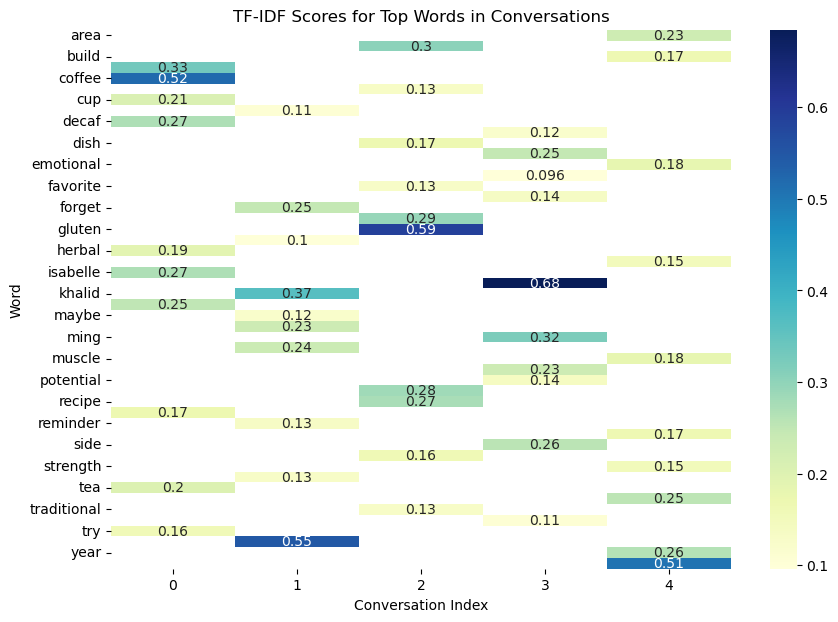

In [25]:

# Define the number of words and conversations to be considered
Nwords = 5
Nconversations = 10

top_tfidf = tfidf_by_word.sort_values(by=['conv_idx','tfidf'], ascending=[True,False]).groupby(['conv_idx']).head(10)

# Only consider the first 5 conversations
top_tfidf = top_tfidf.iloc[:Nwords*Nconversations]

# Function to get top N words by TF-IDF score
def get_top_n_words(df, n=10):
    return df.nlargest(n, 'tfidf')

# Get top 10 words for each conversation
top_words_per_conversation = top_tfidf.groupby('conv_idx', group_keys=False).apply(get_top_n_words)

# Create a pivot table for heatmap
pivot_table = top_words_per_conversation.pivot(index='term', columns='conv_idx', values='tfidf')

# Create the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', cbar=True)
plt.xlabel('Conversation Index')
plt.ylabel('Word')
plt.title('TF-IDF Scores for Top Words in Conversations')
plt.show()

Excercises:

1) Look at the word cloud and add words to the stop list that you think are irrelevant and want to remove.
2) Add the speaker names to the stop list (they are frequent and don't add information)
2) Get rid of the words 'nan' that somehow snuck into our data.
4) Repeat excercise 1, but this time use the topic visualiztion to find out which words are irrelevant


HINT: Loop through each row in the text column, and print the row / save the row index if 'nan ' is one of the words. The space after nan makes sure not include words like nancy e.g.